In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import sys
import os

from emle.models import EMLE
from emle.train._utils import pad_to_max
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, kendalltau

script_dir = os.path.dirname(os.getcwd()) 
parent_dir = os.path.join(script_dir)
sys.path.append(parent_dir)  

from utils import compute_metrics

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [2]:
models_dict = {
    "QM7-Species": "../../emle_models/emle_qm7_aev.mat",
    "QM7-Reference": "../../emle_models/emle_qm7_aev.mat",
    "Bespoke-Iter1-Species": "../../emle_models/ligand_bespoke_iter1.mat",
    "Bespoke-Iter1-Reference": "../../emle_models/ligand_bespoke_iter1.mat",
    "Bespoke-Iter2-Species": "../../emle_models/ligand_bespoke_iter2.mat",
    "Bespoke-Iter2-Reference": "../../emle_models/ligand_bespoke_iter2.mat",
    "Patched-Iter1-Species": "../../emle_models/ligand_patched_species_iter1.mat",
    "Patched-Iter1-Reference": "../../emle_models/ligand_patched_reference_iter1.mat",
    "Patched-Iter2-Species": "../../emle_models/ligand_patched_species_iter2.mat",
    "Patched-Iter2-Reference": "../../emle_models/ligand_patched_reference_iter2.mat",
}

In [3]:

testing_data_paths = {
    "Iter0": "../../data/testing_training_data/merged_testing_data_iter_1.pkl",
    "Iter1": "../../data/testing_training_data/merged_testing_data_iter_2.pkl",
    "Iter2": "../../data/testing_training_data/merged_testing_data_iter_3.pkl",
}

testing_data = {}

for testing_data_name, testing_data_path in testing_data_paths.items():
    data = pkl.load(open(testing_data_path, "rb"))
    xyz_qm = pad_to_max(data["xyz_qm"])
    xyz_mm = pad_to_max(data["xyz_mm"])
    z = pad_to_max(data["z"])
    charges_mm = pad_to_max(data["charges_mm"])
    e_static_ref = torch.tensor(data["e_static"])
    e_ind_ref = torch.tensor(data["e_ind"])
    testing_data[testing_data_name] = {
        "xyz_qm": xyz_qm,
        "xyz_mm": xyz_mm,
        "z": z,
        "charges_mm": charges_mm,
        "e_static_ref": e_static_ref,
        "e_ind_ref": e_ind_ref,
    }

In [4]:
# Evaluate the EMLE energy for each model
emle_energy_dict = {}

HARTEE_TO_KJ_MOL = 2625.5
for iteration, data_dict in testing_data.items():
    xyz_qm = data_dict["xyz_qm"]
    xyz_mm = data_dict["xyz_mm"]
    z = data_dict["z"]
    charges_mm = data_dict["charges_mm"]
    e_static_ref = data_dict["e_static_ref"]
    e_ind_ref = data_dict["e_ind_ref"]

    emle_energy_dict[iteration] = {}

    for model_name, model_path in models_dict.items():
        alpha_mode = "species" if "Species" in model_name else "reference"
        emle_model = EMLE(model=model_path, alpha_mode=alpha_mode).double()

        e_static_emle, e_ind_emle = emle_model.forward(
            z,
            charges_mm,
            xyz_qm,
            xyz_mm,
        )

        emle_energy_dict[iteration][model_name] = {
            "e_static_emle": e_static_emle.detach() * HARTEE_TO_KJ_MOL,
            "e_ind_emle": e_ind_emle.detach() * HARTEE_TO_KJ_MOL,
            "e_total_emle": (e_static_emle.detach() + e_ind_emle.detach()) * HARTEE_TO_KJ_MOL,
        }


with open("emle_energy_dict_per_iter.pkl", "wb") as f:
    pkl.dump(emle_energy_dict, f)

In [5]:
# Compute metrics for each model/iteration
metrics_dict = {}
for iteration, data_dict in testing_data.items():
    metrics_dict[iteration] = {}
    for model_name in models_dict.keys():
        e_static_ref = data_dict["e_static_ref"].numpy() / 4.184
        e_ind_ref = data_dict["e_ind_ref"].numpy() / 4.184
        e_total_ref = e_static_ref + e_ind_ref
        e_static_emle = emle_energy_dict[iteration][model_name]["e_static_emle"].numpy() / 4.184
        e_ind_emle = emle_energy_dict[iteration][model_name]["e_ind_emle"].numpy() / 4.184
        e_total_emle = emle_energy_dict[iteration][model_name]["e_total_emle"].numpy() / 4.184

        mue, mse, kendall, pearson, r2, rmse = compute_metrics(e_static_ref, e_static_emle)
        metrics_dict[iteration][model_name] = {}
        metrics_dict[iteration][model_name]["e_static"] = {}
        metrics_dict[iteration][model_name]["e_static"]["mue"] = mue
        metrics_dict[iteration][model_name]["e_static"]["mse"] = mse
        metrics_dict[iteration][model_name]["e_static"]["kendall"] = kendall
        metrics_dict[iteration][model_name]["e_static"]["pearson"] = pearson
        metrics_dict[iteration][model_name]["e_static"]["r2"] = r2
        metrics_dict[iteration][model_name]["e_static"]["rmse"] = rmse

        mue, mse, kendall, pearson, r2, rmse = compute_metrics(e_ind_ref, e_ind_emle)
        metrics_dict[iteration][model_name]["e_ind"] = {}
        metrics_dict[iteration][model_name]["e_ind"]["mue"] = mue
        metrics_dict[iteration][model_name]["e_ind"]["mse"] = mse
        metrics_dict[iteration][model_name]["e_ind"]["kendall"] = kendall
        metrics_dict[iteration][model_name]["e_ind"]["pearson"] = pearson
        metrics_dict[iteration][model_name]["e_ind"]["r2"] = r2
        metrics_dict[iteration][model_name]["e_ind"]["rmse"] = rmse

        mue, mse, kendall, pearson, r2, rmse = compute_metrics(e_total_ref, e_total_emle)
        metrics_dict[iteration][model_name]["e_total"] = {}
        metrics_dict[iteration][model_name]["e_total"]["mue"] = mue
        metrics_dict[iteration][model_name]["e_total"]["mse"] = mse
        metrics_dict[iteration][model_name]["e_total"]["kendall"] = kendall
        metrics_dict[iteration][model_name]["e_total"]["pearson"] = pearson
        metrics_dict[iteration][model_name]["e_total"]["r2"] = r2
        metrics_dict[iteration][model_name]["e_total"]["rmse"] = rmse

In [6]:
df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] for i in metrics_dict.keys() for j in metrics_dict[i].keys()}, orient='index')
df

e_static  \
Iter0 QM7-Species              {'mue': 1.5997378079396973, 'mse': -0.13654690...   
      QM7-Reference            {'mue': 1.5997378079396973, 'mse': -0.13654690...   
      Bespoke-Iter1-Species    {'mue': 1.1840643815304266, 'mse': -0.57039606...   
      Bespoke-Iter1-Reference  {'mue': 1.1840643815304266, 'mse': -0.57039606...   
      Bespoke-Iter2-Species    {'mue': 1.1635426763988486, 'mse': -0.61937297...   
      Bespoke-Iter2-Reference  {'mue': 1.1635426763988486, 'mse': -0.61937297...   
      Patched-Iter1-Species    {'mue': 0.7312877688018361, 'mse': -0.09088010...   
      Patched-Iter1-Reference  {'mue': 0.7282357986930946, 'mse': -0.08872267...   
      Patched-Iter2-Species    {'mue': 0.7220525892835737, 'mse': -0.02652412...   
      Patched-Iter2-Reference  {'mue': 0.7220525892835737, 'mse': -0.02652412...   
Iter1 QM7-Species              {'mue': 1.7884225863249013, 'mse': -0.17355869...   
      QM7-Reference            {'mue': 1.7884225863249013, 'mse': -0.17355869...   
      Bespoke-Iter1-Species    {'mue': 1.3062235092310521, 'mse': -0.79990570...   
      Bespoke-Iter1-Reference  {'mue': 1.3062235092310521, 'mse': -0.79990570...   
      Bespoke-Iter2-Species    {'mue': 1.2999460357448702, 'mse': -0.83614967...   
      Bespoke-Iter2-Reference  {'mue': 1.2999460357448702, 'mse': -0.83614967...   
      Patched-Iter1-Species    {'mue': 0.8190301145785636, 'mse': -0.32736864...   
      Patched-Iter1-Reference  {'mue': 0.817117839681923, 'mse': -0.326224880...   
      Patched-Iter2-Species    {'mue': 0.785249454883081, 'mse': -0.173072385...   
      Patched-Iter2-Reference  {'mue': 0.785249454883081, 'mse': -0.173072385...   
Iter2 QM7-Species              {'mue': 1.8003030526932027, 'mse': -0.21065853...   
      QM7-Reference            {'mue': 1.8003030526932027, 'mse': -0.21065853...   
      Bespoke-Iter1-Species    {'mue': 1.279353488617714, 'mse': -0.837868819...   
      Bespoke-Iter1-Reference  {'mue': 1.279353488617714, 'mse': -0.837868819...   
      Bespoke-Iter2-Species    {'mue': 1.2962864904359108, 'mse': -0.92572502...   
      Bespoke-Iter2-Reference  {'mue': 1.2962864904359108, 'mse': -0.92572502...   
      Patched-Iter1-Species    {'mue': 0.8086780131826642, 'mse': -0.29103622...   
      Patched-Iter1-Reference  {'mue': 0.8084512779684944, 'mse': -0.30023596...   
      Patched-Iter2-Species    {'mue': 0.795437810899678, 'mse': -0.273462831...   
      Patched-Iter2-Reference  {'mue': 0.795437810899678, 'mse': -0.273462831...   

                                                                           e_ind  \
Iter0 QM7-Species              {'mue': 0.37215565643022935, 'mse': 0.11287914...   
      QM7-Reference            {'mue': 0.31303358056289393, 'mse': 0.06787156...   
      Bespoke-Iter1-Species    {'mue': 0.2915292343677967, 'mse': 0.209429540...   
      Bespoke-Iter1-Reference  {'mue': 0.22128130660325496, 'mse': 0.12836680...   
      Bespoke-Iter2-Species    {'mue': 0.28375081772545263, 'mse': 0.20216987...   
      Bespoke-Iter2-Reference  {'mue': 0.212531062100586, 'mse': 0.1134588021...   
      Patched-Iter1-Species    {'mue': 0.20850737236994654, 'mse': 0.06293003...   
      Patched-Iter1-Reference  {'mue': 0.13498659658381962, 'mse': 0.04020761...   
      Patched-Iter2-Species    {'mue': 0.2137198680144925, 'mse': 0.120975471...   
      Patched-Iter2-Reference  {'mue': 0.1369663269435852, 'mse': 0.077958699...   
Iter1 QM7-Species              {'mue': 0.5088490848727186, 'mse': -0.03887182...   
      QM7-Reference            {'mue': 0.4242122329816242, 'mse': -0.05959227...   
      Bespoke-Iter1-Species    {'mue': 0.32461657115652814, 'mse': 0.16125047...   
      Bespoke-Iter1-Reference  {'mue': 0.23373631219735352, 'mse': 0.08970442...   
      Bespoke-Iter2-Species    {'mue': 0.31493123671742085, 'mse': 0.14940151...   
      Bespoke-Iter2-Reference  {'mue': 0.22824666102336028, 'mse': 0.06371401...   
      Patched-Iter1-Species    {'mue': 

/tmp/ipykernel_1069676/2753020075.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metric_total = df.applymap(lambda x: x[metric])["e_total"].reset_index()
/tmp/ipykernel_1069676/2753020075.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metric_static = df.applymap(lambda x: x[metric])["e_static"].reset_index()
/tmp/ipykernel_1069676/2753020075.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metric_ind = df.applymap(lambda x: x[metric])["e_ind"].reset_index()
/tmp/ipykernel_1069676/2753020075.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, rect=[0, 0, 0.92, 1])


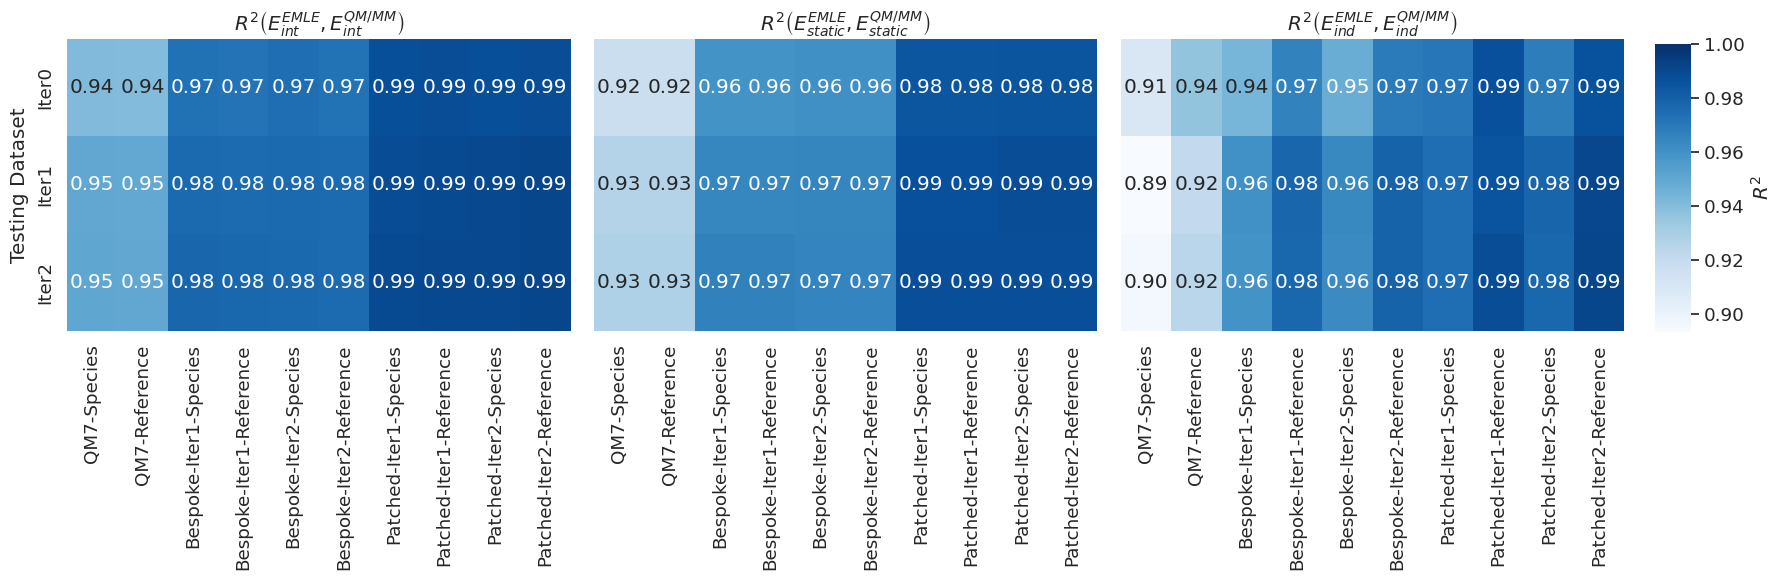

In [30]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True) 

cmap = sns.color_palette("Blues", as_cmap=True)

# Extract metric values
"""
        metrics_dict[iteration][model_name]["e_total"]["mse"] = mse
        metrics_dict[iteration][model_name]["e_total"]["kendall"] = kendall
        metrics_dict[iteration][model_name]["e_total"]["pearson"] = pearson
        metrics_dict[iteration][model_name]["e_total"]["r2"] = r2
"""

metric = "r2"
label = metric.upper()
df_metric_total = df.applymap(lambda x: x[metric])["e_total"].reset_index()
df_metric_static = df.applymap(lambda x: x[metric])["e_static"].reset_index()
df_metric_ind = df.applymap(lambda x: x[metric])["e_ind"].reset_index()

for df_metric in [df_metric_total, df_metric_static, df_metric_ind]:
    df_metric["level_0"] = pd.Categorical(df_metric["level_0"], categories=df_metric["level_0"].unique(), ordered=True)
    df_metric["level_1"] = pd.Categorical(df_metric["level_1"], categories=df_metric["level_1"].unique(), ordered=True)
    df_metric.sort_values(by=["level_0", "level_1"], inplace=True) 

vmin = min(df_metric_total["e_total"].min(), df_metric_static["e_static"].min(), df_metric_ind["e_ind"].min())
vmax = max(df_metric_total["e_total"].max(), df_metric_static["e_static"].max(), df_metric_ind["e_ind"].max())

#vmin = 0
vmax = 1

cbar_ax = fig.add_axes([0.925, 0.43, 0.02, 0.48])  # (x, y, width, height)

sns.heatmap(df_metric_total.pivot(index="level_0", columns="level_1", values="e_total"), 
            annot=True, fmt=".2f", ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cbar_ax, cbar_kws={"label": "$R^{2}$", })
sns.heatmap(df_metric_static.pivot(index="level_0", columns="level_1", values="e_static"), 
            annot=True, fmt=".2f", ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(df_metric_ind.pivot(index="level_0", columns="level_1", values="e_ind"), 
            annot=True, fmt=".2f", ax=axes[2], cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)

for ax, title in zip(axes, ["Total Energy", "Static Energy", "Induction Energy"]):
    ax.set_ylabel("")
    ax.set_xlabel("")

pad = 5
axes[0].set_ylabel("Testing Dataset", labelpad=pad)
axes[0].set_title(r"$R^{2}\left(E^{EMLE}_{int}, E^{QM/MM}_{int}\right)$", pad=pad)
axes[1].set_title(r"$R^{2}\left(E^{EMLE}_{static}, E^{QM/MM}_{static}\right)$", pad=pad)
axes[2].set_title(r"$R^{2}\left(E^{EMLE}_{ind}, E^{QM/MM}_{ind}\right)$", pad=pad)

plt.tight_layout(pad=1.0, rect=[0, 0, 0.92, 1])  
plt.savefig(f"fig3_{metric}_heatmap.pdf", dpi=300)
plt.show()